# Throughput

## Import Data

In [23]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set_style("whitegrid")

In [24]:
data_frames = []

for file in glob.glob("*_1.orunchrt.summary.bench"):
    with open(file) as f:
        data = []
        for l in f:
            temp = json.loads(l)
            if 'name' in temp:
                data.append(temp)
        df = pd.json_normalize(data)
        df['variant'] = file.replace("_1.orunchrt.summary.bench","")
        df['name'] = df['name'].apply(lambda x : x.replace(".orunchrt", ""))
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name','time_secs']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
99,LU_decomposition.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,31.528359,31.464112,0.064000,103768,142329.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,17213419867,242,16777528,65669,6,0,12636169,16830476,3300.656061,5.00+stable+parallel
99,LU_decomposition.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,31.532548,31.455920,0.076009,103816,142329.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,17213419865,240,16777526,65669,6,0,12636169,16830476,3300.656092,5.00.0+trunk
76,LU_decomposition_multicore.12_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,3.513550,41.758338,0.247990,129760,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,17223899886,3861907,20639193,78385,796,0,12922889,17137676,7.878875,5.00+stable+parallel
76,LU_decomposition_multicore.12_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,3.535176,41.925111,0.339944,129272,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,17209895435,2141985,18919243,78169,774,0,12918793,12931081,7.696147,5.00.0+trunk
71,LU_decomposition_multicore.16_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.551650,40.247114,0.271994,138292,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,17212165163,2606270,19383532,80751,626,0,12988425,13008905,9.362124,5.00.0+trunk
71,LU_decomposition_multicore.16_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.621797,41.245689,0.425337,138900,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,17232635170,4630807,21408093,83136,714,0,12967945,17219596,8.846748,5.00+stable+parallel
22,LU_decomposition_multicore.1_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,32.915613,32.823015,0.092019,104092,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,17205052106,10007,16787293,65689,57,0,12640265,12640265,1.337932,5.00.0+trunk
22,LU_decomposition_multicore.1_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,32.957348,32.881072,0.076002,104288,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,17205052228,10067,16787353,65685,53,0,12644361,12644361,1.431780,5.00+stable+parallel
4,LU_decomposition_multicore.20_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.143641,41.896111,0.560697,148012,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,17241232484,5162006,21939242,81448,583,0,13172745,17338380,11.588482,5.00+stable+parallel
4,LU_decomposition_multicore.20_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.188262,42.899583,0.433207,147268,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,17214359371,3022747,19799999,81536,509,0,13107209,13078537,10.865598,5.00.0+trunk


## Prepare multicore data

Filter rows whose names have multicore in them. 

In [19]:
def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
mdf.sort_values(['name','variant','num_domains'])

<ipython-input-19-0147373d3a46>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-19-0147373d3a46>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
<ipython-input-19-0147373d3a46>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,num_domains,ntime_secs,btime_secs
22,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,32.957348,32.881072,0.076002,104288,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,65685,53,0,12644361,12644361,1.431780,5.00+stable+parallel,1,0.956641,31
23,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,16.753557,33.399936,0.092010,106904,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,70643,2399,0,12677129,12677129,2.210111,5.00+stable+parallel,2,1.881890,31
46,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,8.561086,34.093665,0.112005,111424,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,74317,2015,0,12730377,12738569,3.453422,5.00+stable+parallel,4,3.682752,31
79,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,4.554042,36.180178,0.164000,120656,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,76537,1126,0,12808201,12832777,5.229260,5.00+stable+parallel,8,6.923159,31
76,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,3.513550,41.758338,0.247990,129760,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,78385,796,0,12922889,17137676,7.878875,5.00+stable+parallel,12,8.973363,31
71,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.621797,41.245689,0.425337,138900,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,83136,714,0,12967945,17219596,8.846748,5.00+stable+parallel,16,12.025476,31
4,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.143641,41.896111,0.560697,148012,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,81448,583,0,13172745,17338380,11.588482,5.00+stable+parallel,20,14.707854,31
88,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.111667,48.012385,0.776200,156692,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,84890,533,0,21671951,21610511,12.895898,5.00+stable+parallel,24,14.930555,31
22,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,32.915613,32.823015,0.092019,104092,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,65689,57,0,12640265,12640265,1.337932,5.00.0+trunk,1,0.957854,31
23,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,16.950289,33.724582,0.108078,106492,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,71513,2458,0,12677129,12677129,2.220071,5.00.0+trunk,2,1.860048,31


# Time

In [20]:
mdf = mdf.sort_values(['name'])
mdf = mdf.reset_index()
mdf

,index,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,...,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,num_domains,ntime_secs,btime_secs
0,76,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,3.513550,41.758338,0.247990,129760,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,...,78385,796,0,12922889,17137676,7.878875,5.00+stable+parallel,12,8.973363,31
1,79,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,4.565497,36.303080,0.131996,120252,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,...,76745,1091,0,12931081,12824585,5.426909,5.00.0+trunk,8,6.905789,31
2,79,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,4.554042,36.180178,0.164000,120656,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,...,76537,1126,0,12808201,12832777,5.229260,5.00+stable+parallel,8,6.923159,31
3,46,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,8.628215,34.391733,0.087989,111112,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,...,73728,1674,0,12726281,12726281,3.346666,5.00.0+trunk,4,3.654100,31
4,46,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,8.561086,34.093665,0.112005,111424,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,...,74317,2015,0,12730377,12738569,3.453422,5.00+stable+parallel,4,3.682752,31
5,23,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,16.753557,33.399936,0.092010,106904,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,...,70643,2399,0,12677129,12677129,2.210111,5.00+stable+parallel,2,1.881890,31
6,88,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.111667,48.012385,0.776200,156692,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,...,84890,533,0,21671951,21610511,12.895898,5.00+stable+parallel,24,14.930555,31
7,88,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.054402,47.121808,0.487356,156164,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,...,80639,439,0,13434889,13156361,12.848476,5.00.0+trunk,24,15.346732,31
8,23,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,16.950289,33.724582,0.108078,106492,177813.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,...,71513,2458,0,12677129,12677129,2.220071,5.00.0+trunk,2,1.860048,31
9,4,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",2.143641,41.896111,0.560697,148012,285084.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,...,81448,583,0,13172745,17338380,11.588482,5.00+stable+parallel,20,14.707854,31


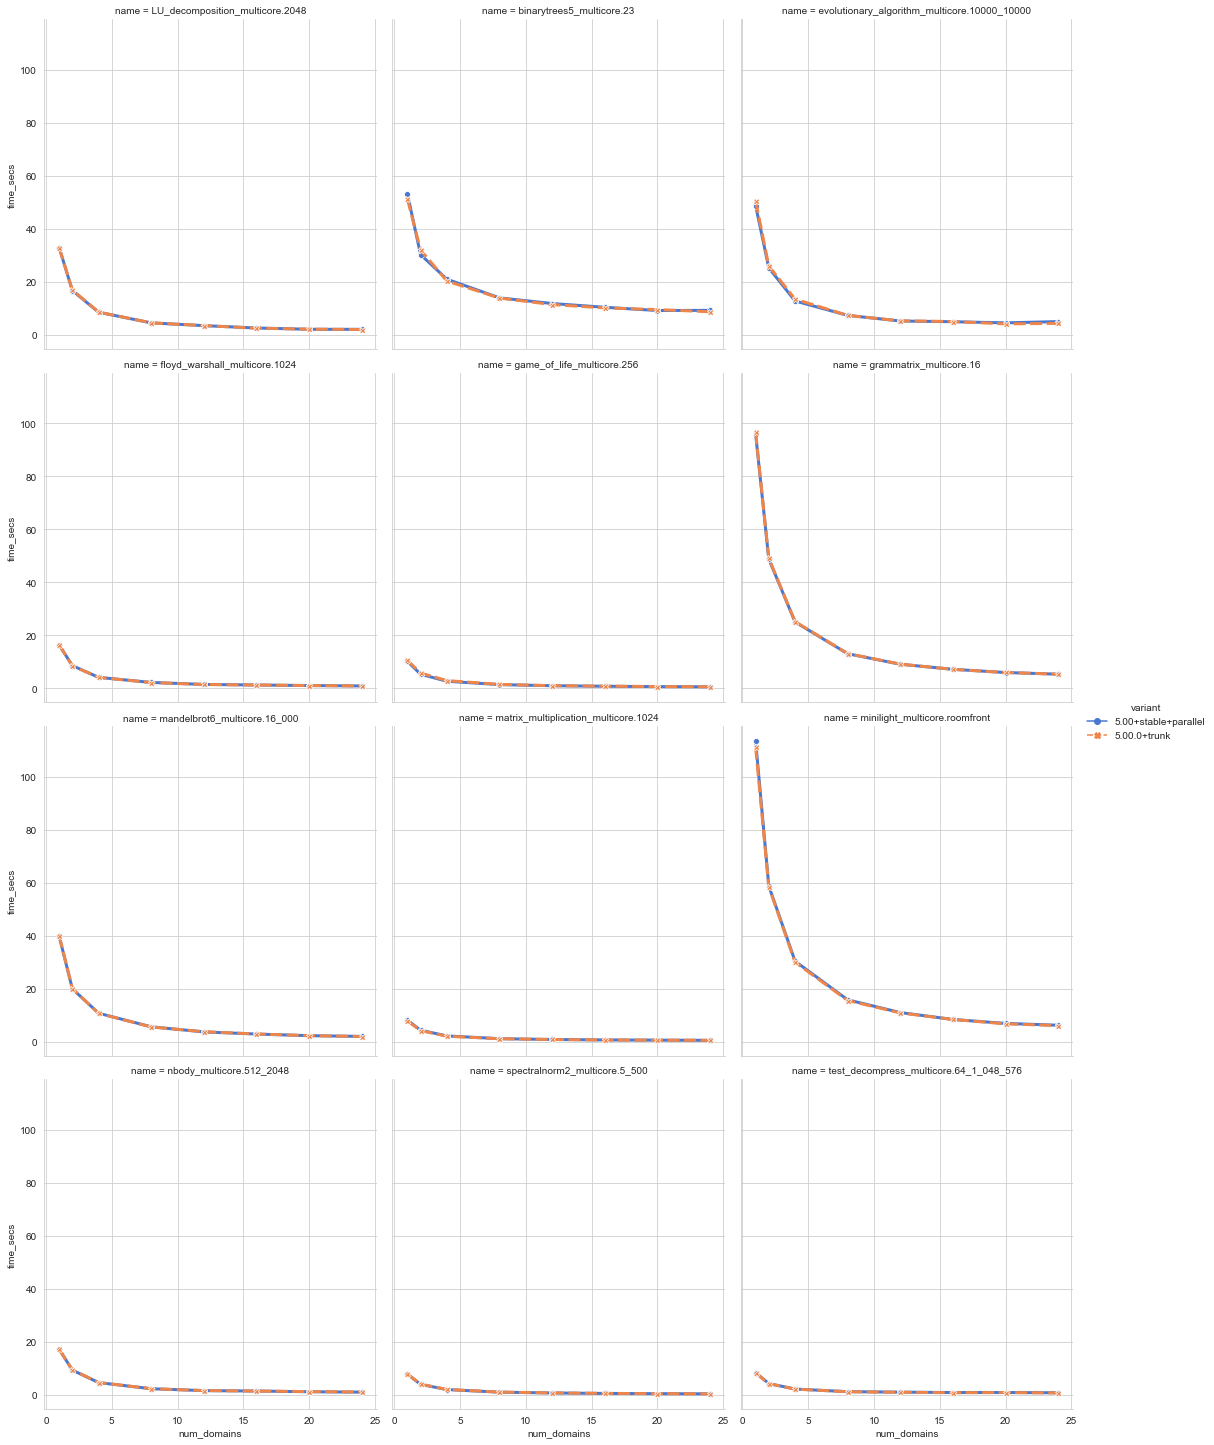

In [21]:
sns.relplot(x='num_domains', y='time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")

## Speedup

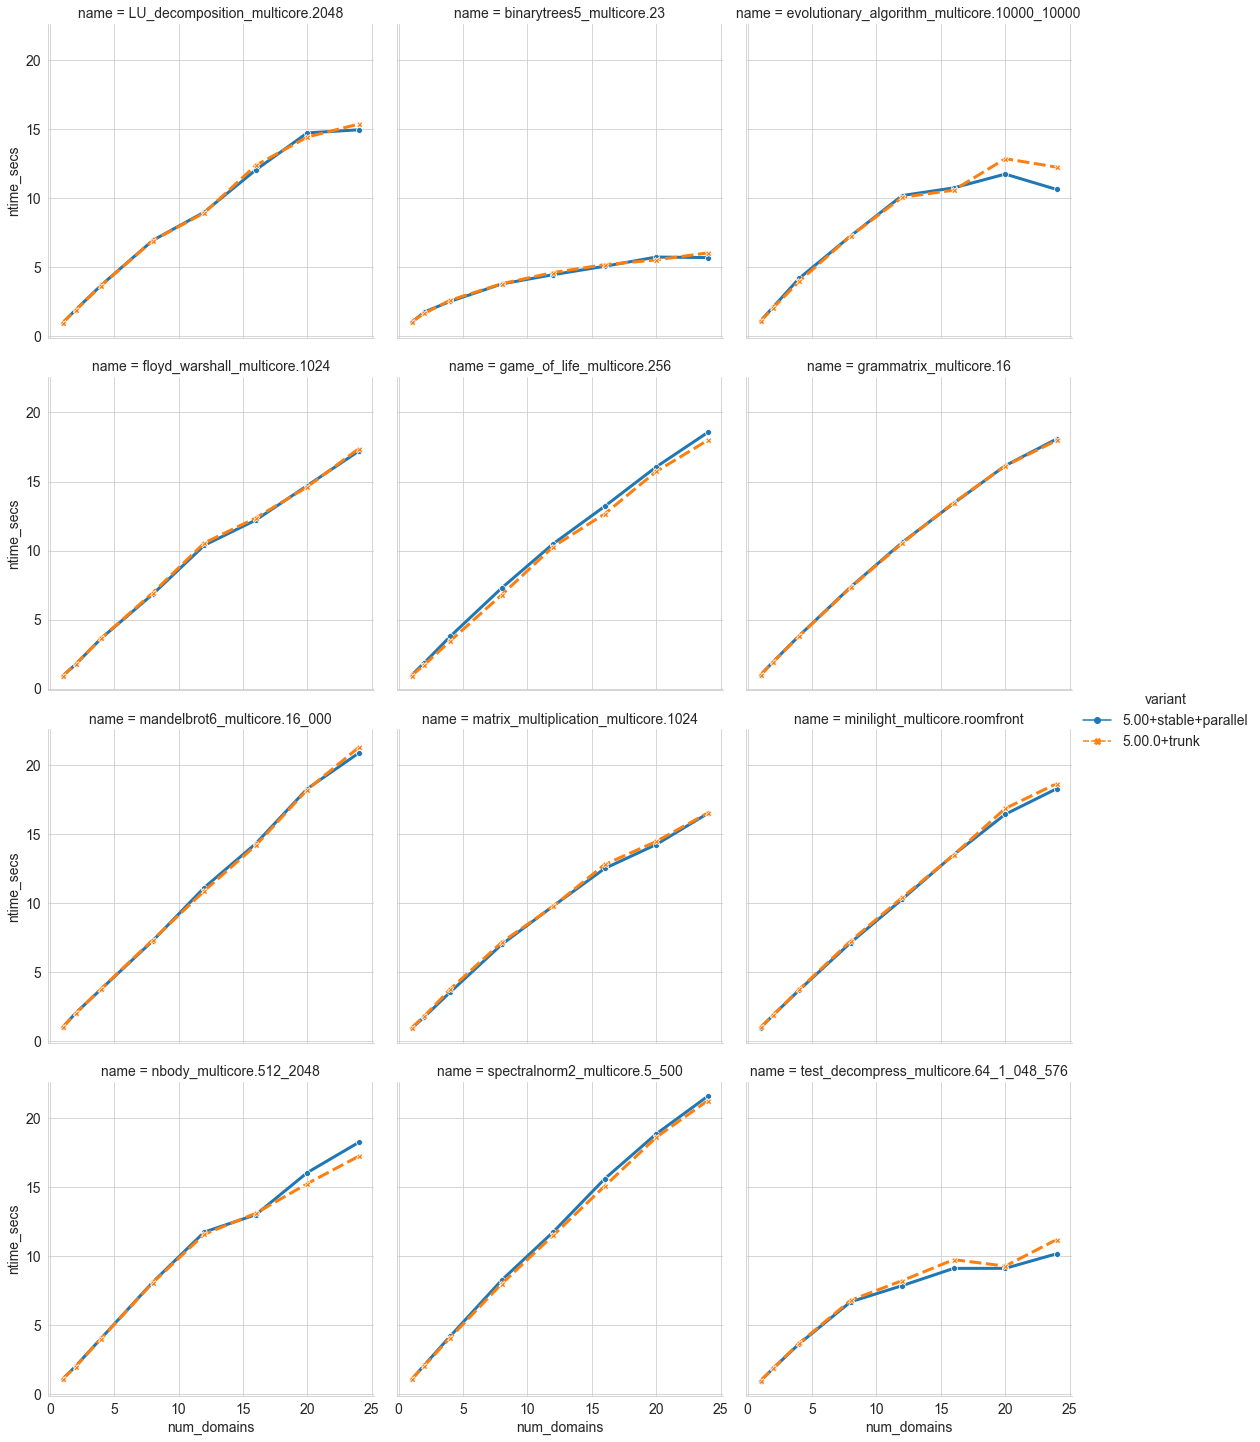

In [22]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
                lw=3)
